This notebook will perform topic modeling with two versions of the World News subreddit data.  
The time data version consists of the title text and the up votes from posted acticles.  
The author data version contains the same features, but aggregated, and includes the author ranking by total up votes.  
Further preprocessing will be performed on the text data, through lemmetization and character cleaning, to create tokens.  
Each set of word tokens will be assembled into a Document Term Matrix (DTM).  
The DTMs will be fed to a Latent Dirichlet Allocation (LDA) engine to divide the articles into similar topics.  
Words that best fit each topic will be shown to assess the nature of the topics, heuristically.  
All aggregated data and constructed datasets will be saved for later use.  
  
Plots will be made for showing:
- Word frequency for each topic from each dataset version  
- Topic frequency for each year 
- Topic frequency for each author rank with up vote trends for all articles

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import numpy as np
import pandas as pd
import re
from ast import literal_eval
import time
from pickle import dump as pkl_dump, load as pkl_load
from joblib import Parallel, delayed, dump, load
import collections

In [3]:
# import NLP tools
import spacy
#import en_core_web_lg
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')
# silence matplotlib watning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Use "my_big_pallette.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


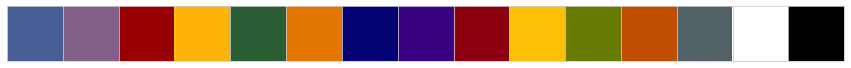

In [5]:
# import and set custom palette module
import my_big_palette as mp
sns.set_palette(sns.color_palette(mp.my_palette))

In [6]:
# free autocomplete from Jedi mind control
%config Completer.use_jedi = False

In [7]:
# read in time dataset and rename last column to match second dataset
time_df = pd.read_csv('../data/time_data.csv', index_col=0, 
                      usecols=['time_created', 
                               'up_votes', 
                               'title']).rename(columns={'title': 'titles'})
time_df.head()

,up_votes,titles
time_created,,
2008-01-25 03:34:06,3,Scores killed in Pakistan clashes
2008-01-25 03:34:35,2,Japan resumes refuelling mission
2008-01-25 03:42:03,3,US presses Egypt on Gaza border
2008-01-25 03:54:50,1,Jump-start economy: Give health care to all
2008-01-25 15:25:20,4,Council of Europe bashes EU&UN terror blacklist


In [8]:
# read in author dataset
author_df = pd.read_csv('../data/author_data.csv', index_col=0, 
                        usecols=['author', 'rank', 'up_votes', 'titles'])
author_df.head()

,up_votes,rank,titles
author,,,
maxwellhill,1985416,top,['Chinese Premier accuses Dalai Lama of master...
anutensil,1531544,top,"['Top 10 discoveries of 2009', 'Mystery behind..."
Libertatea,832102,top,['Life inside the Ecuadorian embassy with Wiki...
DoremusJessup,584380,top,['Human Rights Watch claims $32 billion missin...
Wagamaga,580121,top,['The government wants penalties including pot...


> **TEXT PREPROCESSING**

I will begin by using spaCy for token creation.

In [9]:
# import language model
nlp = spacy.load('en_core_web_lg', disable=['tagger', 'parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))

Because of the way I constructed the titles feature in the author DataFrame, there will be very long text strings.  
I need to increase the upper limit of spaCy's language model, accordingly.

In [10]:
# find length of longest text string
max_title = len(max(open('../data/author_data.csv'), key=len))
print(f'My longest string is {max_title:,} characters.')

My longest string is 1,611,235 characters.


In [11]:
# show longest string accepted by language parser by default
print(f'SpaCy\'s limit is {nlp.max_length:,} characters.')

SpaCy's limit is 1,000,000 characters.


In [12]:
# set maximum length to be a bit larger than longest string in dataset
nlp.max_length = int(max_title * 1.1)
print(f'I have increased the limit to {nlp.max_length:,} characters.')

I have increased the limit to 1,772,358 characters.


In [13]:
# get string of punctuations
punctuations = string.punctuation
# get list of English stop words
stopwords = list(STOP_WORDS)

Now, I will clean the text of stopwords and punctuation, while leaving hyphenated words longer than 2 characters.

In [14]:
def clean_text(data):
    """Return only desired characters from text data"""
    
    # create regex pattern for alphanumeric or hyphenated text at least 3 characters long
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    # replace titles column with cleaned text
    data['titles'] = data['titles'].str.findall(pattern).str.join(' ')
    
    return data

In [15]:
# clean time dataset
clean_text(time_df)
time_df

,up_votes,titles
time_created,,
2008-01-25 03:34:06,3,Scores killed Pakistan clashes
2008-01-25 03:34:35,2,Japan resumes refuelling mission
2008-01-25 03:42:03,3,presses Egypt Gaza border
2008-01-25 03:54:50,1,Jump-start economy Give health care all
2008-01-25 15:25:20,4,Council Europe bashes terror blacklist
...,...,...
2016-11-22 12:12:44,5,Heil Trump Donald Trump alt-right white nation...
2016-11-22 12:12:52,1,There are people speculating that this could M...
2016-11-22 12:17:36,1,Professor receives Arab Researchers Award


In [16]:
# clean author dataset
clean_text(author_df)
author_df

,up_votes,rank,titles
author,,,
maxwellhill,1985416,top,Chinese Premier accuses Dalai Lama mastermindi...
anutensil,1531544,top,Top discoveries 2009 Mystery behind what makes...
Libertatea,832102,top,Life inside the Ecuadorian embassy with Wikile...
DoremusJessup,584380,top,Human Rights Watch claims billion missing from...
Wagamaga,580121,top,The government wants penalties including poten...
...,...,...,...
davitruiz,0,bottom,Madrid train strike the day before holiday wee...
davie18,0,bottom,Remember that letter Sainsbury where little gi...
davidstern350,0,bottom,UOSSM Urges the International Organizations ex...


I will build a Joblib pipeline for multi-worker tokenization.

In [17]:
def lemmatize_text(text_data):
    """Returns lemmatized and lower case tokens without stopwords"""
    
    tokens = [str(token.lemma_).lower() for token in text_data
                  if token.is_alpha and token.text.lower() not in stopwords] 
    
    return tokens

In [18]:
def tokenize_chunk(chunk):
    """Returns tokenized chunk of text data"""
    
    tokens = []
    for text_data in nlp.pipe(chunk, batch_size=20):
        tokens.append(lemmatize_text(text_data))
        
    return tokens

In [19]:
def make_chunks(text_data, chunksize):
    """Returns text data broken into chunks"""
    
    chunks = (text_data[idx: idx + chunksize] 
              for idx in range(0, len(text_data), chunksize))
    
    return chunks

In [20]:
def flatten(nested_list):
    """Returns a flattend list from a nested list"""
    
    flat_list = [item for sublist in nested_list for item in sublist]
    
    return flat_list

In [21]:
def parallel_tokenization(text_data, chunksize):
    """Returns parallel processed tokens"""
    
    # instantiate parallel helper
    executor = Parallel(n_jobs=-1, backend='multiprocessing', prefer="processes")
    # create jobs to distribute execution of chunk tokenizing function
    jobs = delayed(tokenize_chunk)
    # create task chain
    task_chain = (jobs(chunk) for chunk in make_chunks(text_data, chunksize=chunksize))
    # execute parallel jobs
    nested_list = executor(task_chain)
    
    return flatten(nested_list)

Now, I'm ready to create the word tokens to be used for the LDA model.

In [22]:
%%time
# tokenize time data
time_df['tokens'] = parallel_tokenization(time_df['titles'], chunksize=1000)
time_df.drop('titles', inplace=True, axis=1)
time_df

CPU times: user 2.41 s, sys: 795 ms, total: 3.21 s
Wall time: 8.99 s


,up_votes,tokens
time_created,,
2008-01-25 03:34:06,3,"[scores, kill, pakistan, clash]"
2008-01-25 03:34:35,2,"[japan, resume, refuel, mission]"
2008-01-25 03:42:03,3,"[press, egypt, gaza, border]"
2008-01-25 03:54:50,1,"[jump, start, economy, health, care]"
2008-01-25 15:25:20,4,"[council, europe, bash, terror, blacklist]"
...,...,...
2016-11-22 12:12:44,5,"[heil, trump, donald, trump, alt, right, white..."
2016-11-22 12:12:52,1,"[people, speculate, madeleine, mccann]"
2016-11-22 12:17:36,1,"[professor, receive, arab, researchers, award]"


In [23]:
%%time
# tokenize author data
author_df['tokens'] = parallel_tokenization(author_df['titles'], chunksize=1000)
author_df.drop('titles', inplace=True, axis=1)
author_df

CPU times: user 997 ms, sys: 687 ms, total: 1.68 s
Wall time: 43.9 s


,up_votes,rank,tokens
author,,,
maxwellhill,1985416,top,"[chinese, premier, accuse, dalai, lama, master..."
anutensil,1531544,top,"[discovery, mystery, make, stradivarius, speci..."
Libertatea,832102,top,"[life, inside, ecuadorian, embassy, wikileaks,..."
DoremusJessup,584380,top,"[human, rights, watch, claim, billion, miss, a..."
Wagamaga,580121,top,"[government, want, penalty, include, potential..."
...,...,...,...
davitruiz,0,bottom,"[madrid, train, strike, day, holiday, weekend,..."
davie18,0,bottom,"[remember, letter, sainsbury, little, girl, sa..."
davidstern350,0,bottom,"[uossm, urges, international, organizations, e..."


The tokens are stuck in lists.  
I will fix that with a quick function.

In [24]:
def list_to_string(data):
    """Returns long string from list of strings"""
    long_string = ' '.join(data)
    
    return long_string

In [25]:
# extract tokens from DataFrame
time_tokens = time_df['tokens'].apply(list_to_string)
author_tokens = author_df['tokens'].apply(list_to_string)

In [26]:
# observe time data tokenization
time_tokens.head()

time_created
2008-01-25 03:34:06              scores kill pakistan clash
2008-01-25 03:34:35             japan resume refuel mission
2008-01-25 03:42:03                 press egypt gaza border
2008-01-25 03:54:50          jump start economy health care
2008-01-25 15:25:20    council europe bash terror blacklist
Name: tokens, dtype: object

In [27]:
# observe author data tokenization
author_tokens.head()

author
maxwellhill      chinese premier accuse dalai lama mastermind r...
anutensil        discovery mystery make stradivarius special co...
Libertatea       life inside ecuadorian embassy wikileaks found...
DoremusJessup    human rights watch claim billion miss angola a...
Wagamaga         government want penalty include potential jail...
Name: tokens, dtype: object

> **TOPIC MODELING**

Next, I will do the topic modeling.  
First, I will create a DTM, or bag of words (BOW), for each set of data.

In [28]:
# instantiate CountVectorizer objects
time_cv = CountVectorizer(max_df=0.95, min_df=5)
author_cv = CountVectorizer(max_df=0.95, min_df=5)

In [29]:
%%time
# transform tokens into Document-term Matries
time_dtm = time_cv.fit_transform(time_tokens)
author_dtm = author_cv.fit_transform(author_tokens)

CPU times: user 7.26 s, sys: 84 ms, total: 7.34 s
Wall time: 7.35 s


In [30]:
# save vectorizers and matrices
pkl_dump(time_cv.vocabulary_, open('../saved_models/time_vocab.pkl', 'wb'))
pkl_dump(author_cv.vocabulary_, open('../saved_models/author_vocab.pkl', 'wb'))
pkl_dump(time_dtm, open('../saved_models/time_dtm.pkl', 'wb'))
pkl_dump(author_dtm, open('../saved_models/author_dtm.pkl', 'wb'))

I will choose 10 topics to model.  
This choice seems reasonable given the subreddit theme of World News.  
Other values should be tried to get the most useful results for data analysis.

In [31]:
# define number of topics to model
num_topics = 10

In [32]:
# instantiate Latent Dirichlet Allocation(LDA) objects
time_lda = LatentDirichletAllocation(n_components=num_topics, 
                                     random_state=27, n_jobs = -1)
author_lda = LatentDirichletAllocation(n_components=num_topics, 
                                       random_state=27, n_jobs = -1)

In [33]:
%%time
# model time topics with LDA
time_lda.fit(time_dtm)

CPU times: user 26.6 s, sys: 1.83 s, total: 28.4 s
Wall time: 3min 3s


LatentDirichletAllocation(n_jobs=-1, random_state=27)

In [34]:
%%time
# model author topics with LDA
author_lda.fit(author_dtm)

CPU times: user 7.21 s, sys: 603 ms, total: 7.82 s
Wall time: 1min 4s


LatentDirichletAllocation(n_jobs=-1, random_state=27)

In [35]:
# save sklearn lda models
dump(time_lda, '../saved_models/time_lda.joblib')
dump(author_lda, '../saved_models/author_lda.joblib')

['../saved_models/author_lda.joblib']

I will get the distribution of the values the LDA model calculated by topic for each observation.

In [36]:
# get topic LDA values for time data topics
time_results = time_lda.transform(time_dtm)
time_results

array([[0.02000012, 0.02      , 0.02000044, ..., 0.81999115, 0.02000002,
        0.02000275],
       [0.59376566, 0.02000062, 0.02000028, ..., 0.02000157, 0.02000724,
        0.24621999],
       [0.81995883, 0.02000523, 0.02000027, ..., 0.02001056, 0.02000147,
        0.02000506],
       ...,
       [0.19796531, 0.29777125, 0.01667114, ..., 0.01666673, 0.01666796,
        0.0166675 ],
       [0.01250198, 0.01250113, 0.01250074, ..., 0.01250218, 0.0125018 ,
        0.4294018 ],
       [0.40947726, 0.01000006, 0.01000012, ..., 0.01000069, 0.0100001 ,
        0.01000075]])

In [37]:
# get topic LDA values for author data topics
author_results = author_lda.transform(author_dtm)
author_results

array([[0.05353296, 0.13133334, 0.00972265, ..., 0.53852767, 0.03134434,
        0.00423646],
       [0.03990214, 0.56473485, 0.00830622, ..., 0.20547911, 0.00283088,
        0.00194072],
       [0.08018048, 0.21257229, 0.00223081, ..., 0.21754146, 0.0061095 ,
        0.00416484],
       ...,
       [0.01111521, 0.01111507, 0.01111221, ..., 0.01111368, 0.01111398,
        0.01111425],
       [0.01666861, 0.84996968, 0.01666868, ..., 0.01666878, 0.01666925,
        0.01667058],
       [0.01250269, 0.0125018 , 0.01250028, ..., 0.01250107, 0.01250041,
        0.0125012 ]])

Using these values, I will assign the articles to their most similar topics.

In [38]:
# add topics to time DataFrame
time_df['lda_topic'] = time_results.argmax(axis=1)
time_df.head(20)

,up_votes,tokens,lda_topic
time_created,,,
2008-01-25 03:34:06,3,"[scores, kill, pakistan, clash]",7
2008-01-25 03:34:35,2,"[japan, resume, refuel, mission]",0
2008-01-25 03:42:03,3,"[press, egypt, gaza, border]",0
2008-01-25 03:54:50,1,"[jump, start, economy, health, care]",2
2008-01-25 15:25:20,4,"[council, europe, bash, terror, blacklist]",8
2008-01-25 19:04:49,15,"[hay, presto, farmer, unveil, illegal, mock, t...",6
2008-01-25 19:30:38,5,"[strikes, protests, gridlock, poland, ukraine,...",7
2008-01-28 16:11:02,0,"[mismanagement, program]",4
2008-01-28 22:13:16,4,"[nicolas, sarkozy, threaten, sue, ryanair]",1


In [39]:
# add topics to author DataFrame
author_df['lda_topic'] = author_results.argmax(axis=1)
author_df.head(20)

,up_votes,rank,tokens,lda_topic
author,,,,
maxwellhill,1985416,top,"[chinese, premier, accuse, dalai, lama, master...",7
anutensil,1531544,top,"[discovery, mystery, make, stradivarius, speci...",1
Libertatea,832102,top,"[life, inside, ecuadorian, embassy, wikileaks,...",4
DoremusJessup,584380,top,"[human, rights, watch, claim, billion, miss, a...",0
Wagamaga,580121,top,"[government, want, penalty, include, potential...",1
NinjaDiscoJesus,492582,top,"[sarkozy, paris, hospital, bruni, set, birth, ...",1
madazzahatter,428966,top,"[tokyo, electric, power, detect, high, radiati...",4
madam1,390541,top,"[video, tour, new, improve, million, dollar, b...",0
davidreiss666,338306,top,"[algerian, christian, convert, find, guilty, w...",0


In [40]:
# save both DataFrames to CSV files
time_df.to_csv('../data/time_tokens.csv')
author_df.to_csv('../data/author_tokens.csv')

> **TOPIC ANALYSIS**

To begin the analysis, I will observe the top 15 words from each topic for each data version.

In [41]:
# observe top words in each topic for time DataFrame
time_topic_top_15 = {}

for topic, word_probs in enumerate(time_lda.components_):
    # get value for word that best fits topic
    top_score = word_probs.max()
    # build sorted top word dict for topic
    time_topic_top_15[topic] = [(time_cv.get_feature_names()[i], 
                                 word_probs[i] / top_score)
                                for i in word_probs.argsort()[-15:]][::-1]
    
    print(f'Top 15 Word for Time Topic {topic}:')
    print([i[0] for i in time_topic_top_15[topic]])
    print('\n')

Top 15 Word for Time Topic 0:
['israel', 'war', 'israeli', 'palestinian', 'nuclear', 'iran', 'gaza', 'syria', 'say', 'peace', 'west', 'weapon', 'hamas', 'talk', 'plant']


Top 15 Word for Time Topic 1:
['china', 'drug', 'president', 'woman', 'year', 'venezuela', 'mexico', 'election', 'old', 'win', 'spain', 'chinese', 'party', 'mexican', 'man']


Top 15 Word for Time Topic 2:
['child', 'die', 'sex', 'woman', 'year', 'pope', 'death', 'gay', 'abuse', 'case', 'say', 'ebola', 'rape', 'hospital', 'church']


Top 15 Word for Time Topic 3:
['kill', 'police', 'isis', 'state', 'islamic', 'attack', 'iraq', 'man', 'shoot', 'al', 'dead', 'arrest', 'death', 'group', 'say']


Top 15 Word for Time Topic 4:
['say', 'saudi', 'right', 'government', 'country', 'president', 'oil', 'human', 'change', 'climate', 'egypt', 'state', 'new', 'arabia', 'world']


Top 15 Word for Time Topic 5:
['new', 'minister', 'government', 'prime', 'world', 'say', 'internet', 'million', 'people', 'law', 'india', 'country', 'pla

Some of the topics appear broad (1 ==> China or Drug War, 5 ==> State Affairs or Legislation).  
Other topics are more focused (0 ==> Israeli Occupation, 9 ==> Nuclear Aspiring Nations).  
Choosing fewer topics to model may merge the broad topics into the others.

In [42]:
# observe top words in each topic for author DataFrame
author_topic_top_15 = {}

for topic, word_probs in enumerate(author_lda.components_):
    # get value for word that best fits topic
    top_score = word_probs.max()
    # build sorted top word dict for topic
    author_topic_top_15[topic] = [(author_cv.get_feature_names()[i], 
                                   word_probs[i] / top_score) 
                                  for i in word_probs.argsort()[-15:]][::-1]
    
    print(f'Top 15 Word for Author Topic {topic}:')
    print([i[0] for i in author_topic_top_15[topic]])
    print('\n')

Top 15 Word for Author Topic 0:
['syria', 'say', 'president', 'kill', 'iran', 'syrian', 'government', 'egypt', 'rebel', 'protest', 'attack', 'leader', 'military', 'new', 'war']


Top 15 Word for Author Topic 1:
['world', 'climate', 'say', 'new', 'year', 'change', 'people', 'global', 'find', 'million', 'ebola', 'report', 'country', 'oil', 'water']


Top 15 Word for Author Topic 2:
['korea', 'china', 'north', 'south', 'korean', 'japan', 'chinese', 'missile', 'sea', 'nuclear', 'kim', 'test', 'jong', 'military', 'launch']


Top 15 Word for Author Topic 3:
['kill', 'isis', 'attack', 'syria', 'islamic', 'state', 'turkey', 'saudi', 'say', 'iraq', 'syrian', 'pakistan', 'bomb', 'force', 'turkish']


Top 15 Word for Author Topic 4:
['russia', 'ukraine', 'say', 'china', 'russian', 'putin', 'new', 'minister', 'military', 'state', 'country', 'president', 'government', 'deal', 'japan']


Top 15 Word for Author Topic 5:
['pope', 'german', 'canada', 'world', 'snowden', 'say', 'spy', 'nsa', 'year', 'ne

Again, we have at least one broad topic (1 ==> Climate Change or New Years).  
With the author grouping, we have more of the focused topics (0 ==> Syrian War, 3 ==> ISIS & Islamic State).  
It would seem that the author version of the data receives a better sorting among the 10 topics.

In [43]:
# save top 15 word dictionaries
pkl_dump(time_topic_top_15, open(
    '../data/dicts_&_lists/time_topic_top_15_dict.pkl', 'wb'))
pkl_dump(author_topic_top_15, open(
    '../data/dicts_&_lists/author_topic_top_15_dict.pkl', 'wb'))

> **VISUALIZATIONS**

Finally, I will create some plots to compare how each aggregation of the dataset was processed by the LDA model.

In [44]:
def get_word_freq(bow, vectorizer):
    """Returns word text with max min normalized word frequency"""
    # get summation for each token in whole dataset
    token_sum_matrix = bow.sum(axis=0)
    # get word text mapping and word count for every token in DataSet
    word_sum = [(word, token_sum_matrix[0, idx]) for word, idx 
                in vectorizer.vocabulary_.items()]
    # sort word count mapping in descending order
    word_sum = sorted(word_sum, key=lambda x: x[1], reverse=True)
    # get count of most used word
    most_freq = max([i[1] for i in word_sum])
    # convert word count mapping to max min normalization
    word_frequency = [(i[0], i[1] / most_freq) for i in word_sum]

    
    return word_frequency

Here, I will get a sorted mapping of all the words seen in the entire dataset and their min max normalized frequencies.

In [45]:
# get normalized word to frequency mapping
word_freq = get_word_freq(time_dtm, time_cv)
word_freq[:10]

[('say', 1.0),
 ('china', 0.7850612026089288),
 ('kill', 0.7326443696578014),
 ('new', 0.6991690740685589),
 ('attack', 0.6060398487059594),
 ('syria', 0.5664294010781189),
 ('russia', 0.5573160198945707),
 ('world', 0.5412335825118385),
 ('government', 0.5027548619590791),
 ('year', 0.49900229323644163)]

In [46]:
# save word to frequency mapping
pkl_dump(word_freq, open('../data/dicts_&_lists/word_freq_lst.pkl', 'wb'))

Now, I will compare the relationship between the topics and their most common words, as it relates to those across all data. 

In [47]:
def plot_top_words(data, data_name, word_freq_lst):
    """Plots top word frequencies for each topic and for all titles"""
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    fig.suptitle('Top ' + data_name + ' Topic Words vs. All Top Words', 
                 size=25, y=1.0)
    # get 30 most frequent words in all titles
    most_freq_words = [i[0] for i in word_freq_lst[:30]]
    # set axis for first 5 topics

    # plot all data
    for ax_idx, ax in enumerate(axes.flatten()):
        sns.lineplot(data=dict(word_freq_lst[:30]), color=mp.colors(-1), 
                     label='All Titles', ax=ax, marker='o')
        
        for topic in range(ax_idx * 5, (ax_idx+ 1) * 5):
            # get most frequent words and normalized frequencies for topic
            topic_most_freq = [(word, freq) for word, freq 
                               in data[topic] 
                               if word in most_freq_words]
            # plot topic data
            sns.lineplot(data=dict(topic_most_freq), label='Topic ' + str(topic), 
                 ax=ax, marker='o', linestyle='--', color=mp.colors(topic)) 
                
        ax.set_xticklabels(labels=most_freq_words, rotation=65, fontsize=14)
        ax.set_ylabel('Word Frequency', fontsize=20)
        ax.legend(loc=7, bbox_to_anchor=(1.16, 0.5), fontsize=15)

    ax.set_xlabel('30 Most Frequent Words', fontsize=22)
    
    fig.tight_layout()

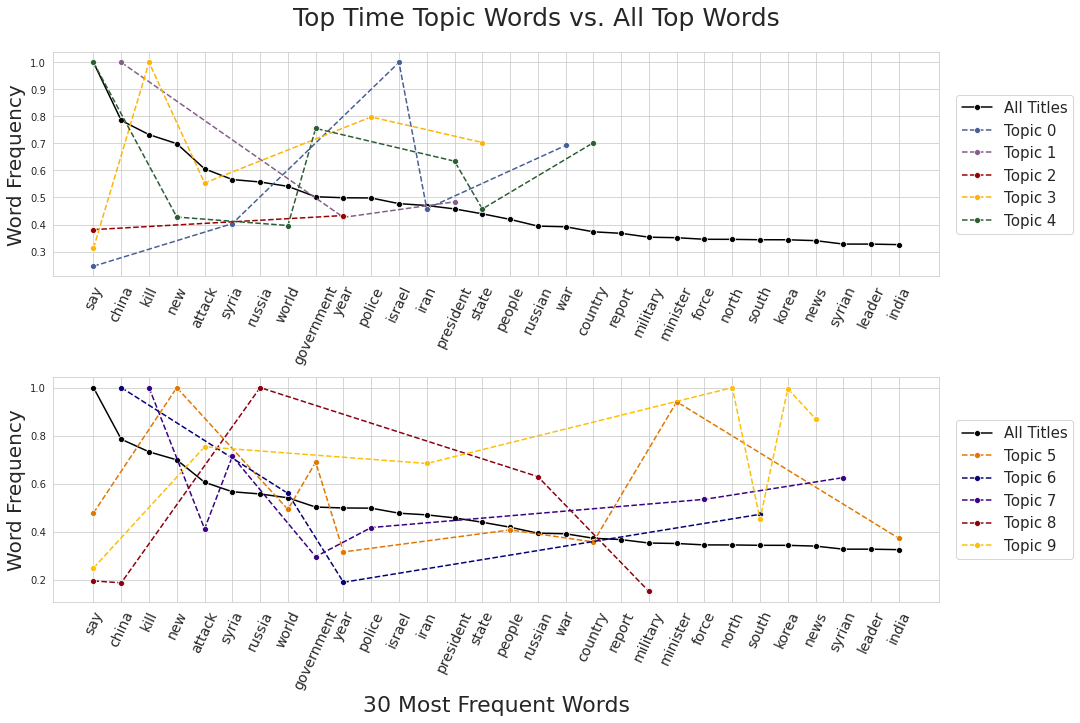

In [48]:
# plot top words for topics, using time DataFrame
plot_top_words(time_topic_top_15, 'Time', word_freq)

For the time dataset, topic 1 seems to follow the overall trend the best.  
Topics 0, 3, 8, & 9 appear to trend in the opposite direction, as the full dataset.

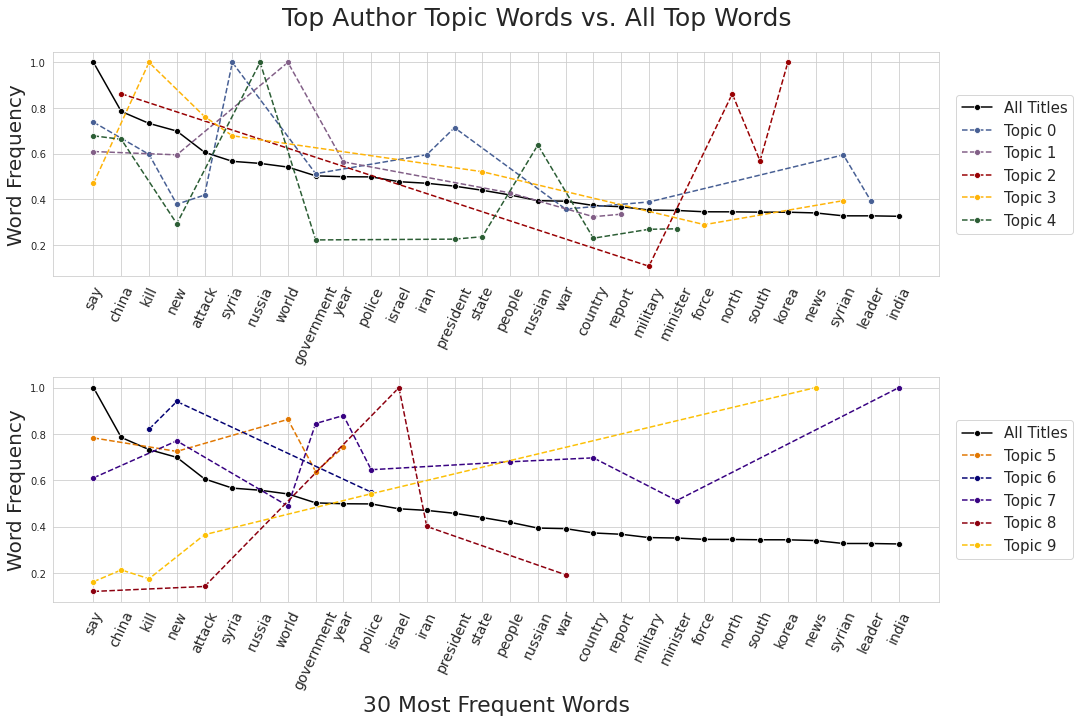

In [49]:
# plot top words for topics, using author DataFrame
plot_top_words(author_topic_top_15, 'Author', word_freq)

Topics 1 & 3 from the modeling of the author dataset follow the general trend.  
Topics 4, 8, & 9 are more concentrated in their particular word frequencies.

To a certain extent, the more divergent topics are the ones with a clearer focus.  
This is an effective method of visualizing the quality of the topics.  
Perhaps an optimal number of topics could be chosen, such that the divergences of these topic plots are maximized.

Now, I will get min max normalized topic frequencies by the year each article was posted.

In [50]:
def agg_years(data):
    """Returns DataFrame of max min normalized yearly frequencies grouped by topic"""
    # get DataFrame with year and topic data
    topic_df = pd.DataFrame(data.index.str[:4]).join(
        time_df.reset_index()['lda_topic'].to_frame()) 
    # aggregate year data by topic
    gb_df = topic_df.groupby('lda_topic').agg(
        years=('time_created', collections.Counter))
    # convert single column of Counter objects to many columns of DataFrame
    df = gb_df.join(pd.DataFrame(
        gb_df['years'].tolist(), index=gb_df.index)).drop('years', axis=1).fillna(0)
    # apply min max normalization
    df = (df - df.min()) / (df.max() - df.min())
    
    return df

In [51]:
# get normalized topic by year frequencies DataFrame
year_topic_df = agg_years(time_df)
year_topic_df

,2008,2009,2010,2011,2012,2013,2014,2015,2016
lda_topic,,,,,,,,,
0,0.561673,0.700709,0.505255,0.576896,0.400616,0.283885,0.412421,0.218065,0.000000
1,0.705135,0.479078,0.263527,0.397354,0.741525,0.313171,0.139030,0.045554,0.175799
2,0.447856,0.516312,0.293889,0.130640,0.301618,0.408389,0.274203,0.106293,0.094178
3,0.651138,0.362057,0.390035,0.322466,0.542373,0.409860,0.607165,1.000000,0.739346
4,0.234516,0.241489,0.168159,0.626742,0.662943,0.372627,0.407753,0.717126,0.643836
5,1.000000,1.000000,1.000000,0.647531,1.000000,1.000000,0.605845,0.915623,1.000000
6,0.622022,0.408156,0.372129,0.493740,0.884438,0.702134,0.438908,0.804477,0.934741
7,0.069878,0.000000,0.034644,1.000000,0.953775,0.378955,0.510859,0.648873,0.756279
8,0.300159,0.003191,0.091475,0.268604,0.114792,0.000000,1.000000,0.974640,0.673896


Now, I can plot these results to compare how the topics have changed over the years.

In [52]:
def plot_topic_by_year(data):
    """Plots topic frequency for each year"""
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    fig.suptitle('Topic Frequency by Year', 
                 size=25, y=1.0)

    # set axis for first 5 years
    ax = axes.flatten()[0]
    # remove x label for first subplot
    ax.set_xlabel(' ')
    for year in data.columns:
        if int(year) > 2012:
            # set axis for last 4 years
            ax = axes.flatten()[1]
            
        # plot year data
        sns.lineplot(data=data[year], label=year, 
                     ax=ax, marker='o')
        
        ax.set_xticks(np.arange(len(data.index)))
        ax.set_xticklabels(labels=data.index, fontsize=15)
        
        ax.set_ylabel('Topic Frequency', fontsize=20)
        ax.legend(fontsize=15)

    ax.set_xlabel('LDA Topic', fontsize=22, labelpad=15)
    
    fig.tight_layout()

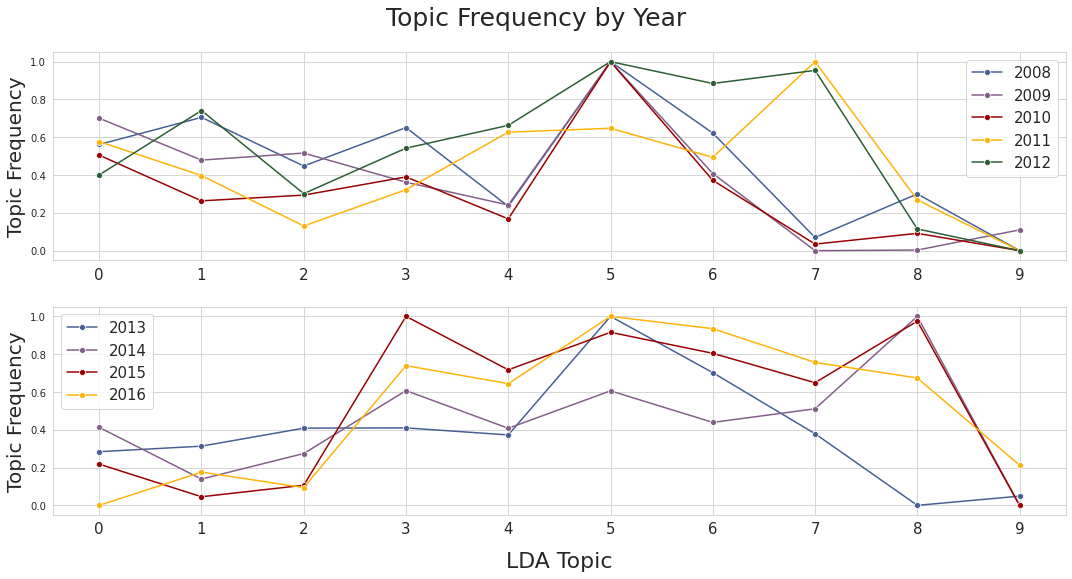

In [53]:
# plot topic frequency by year
plot_topic_by_year(year_topic_df)

Topic 3 (ISIS, Islamic State) peaks in 2015 (Iraq retakes Ramadi).  
Topic 4 (Saudi Arabia, government, Egypt) has a peak in 2011 and 2012 (Arab Spring).

Finally, I will get the min max topic frequencies for each rank of author.  
Recall, the top authors numbered only 60, but accounted for 25% of all up votes.  
I will include the min max frequencies for all up votes summed over each topic for comaprison.

In [54]:
def agg_up_votes(data):
    """Returns DataFrame of max min normalized author rank frequencies \
       and up vote sums grouped by topic"""
    
    # aggregate up votes by sums and ranks by counts grouped by topic
    df = data.groupby('lda_topic').agg(
        total_up_votes=('up_votes', np.sum), 
        ranks=('rank', collections.Counter))
    # convert single column of Counter objects to three rank columns
    df = df.join(pd.DataFrame(
        df['ranks'].tolist(), index=df.index)).drop('ranks', axis=1).fillna(0)
    # apply min max normalization
    df = (df - df.min()) / (df.max() - df.min())
    # rename columns to reflect aggregation and normalization
    df.rename(columns={'total_up_votes':'up_votes_freq', 
                       'top':'top_freq', 
                       'middle':'middle_freq', 
                       'bottom':'bottom_freq'}, inplace=True)
    
    return df

In [55]:
# get normalized topic by rank and up votes frequencies DataFrame
rank_topic_df = agg_up_votes(author_df)
rank_topic_df

,up_votes_freq,top_freq,middle_freq,bottom_freq
lda_topic,,,,
0,0.535616,0.466667,0.429280,0.426179
1,0.712567,0.800000,0.501241,0.320018
2,0.000000,0.133333,0.000000,0.000000
3,0.664000,0.533333,0.972705,0.682901
4,0.882926,1.000000,0.741935,0.337225
5,0.317785,0.200000,0.496278,0.747427
6,0.145600,0.066667,0.218362,0.947304
7,1.000000,0.666667,1.000000,1.000000
8,0.068788,0.133333,0.062035,0.080350


In [56]:
# save data aggregated by topic
year_topic_df.to_csv('../data/year_topic.csv')
rank_topic_df.to_csv('../data/rank_topic.csv')

In the final plot, the comparison between the different author ranks, with respect to the topics posted, can be seen.

In [57]:
def plot_topic_by_rank(data):
    """Plots topic frequency for each author rank and up votes for all titles"""
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    fig.suptitle('Topic Frequency by Author Rank', 
                 size=20, y=1.0)

    # remove x label for first subplot
    ax.set_xlabel(' ')
    # convert column names to be capitalized with spaces instead of underscores
    labels = list(map(lambda x: ' '.join(x.split('_')).title(), data.columns))
    
    for idx, freq in enumerate(data.columns):
        if idx !=0:
        # plot rank data
            sns.lineplot(data=data[freq], label=labels[idx], linestyle='--', 
                         ax=ax, marker='o')
        else:
            # plot all data
            sns.lineplot(data=data[freq], label=labels[idx], 
                         ax=ax, marker='o', color=mp.colors(-1))
                
        ax.set_xticks(np.arange(len(data.index)))
        ax.set_xticklabels(labels=data.index, fontsize=12)
        
        ax.set_ylabel('Topic Frequency', fontsize=15)
        ax.legend(fontsize=10)

    ax.set_xlabel('LDA Topic', fontsize=15, labelpad=15)
        
    fig.tight_layout()

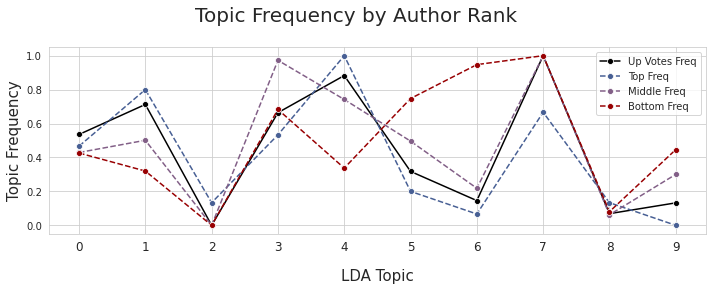

In [58]:
# plot topic frequency by rank
plot_topic_by_rank(rank_topic_df)

The top ranked authors seemed to follow the overall trend fairly tightly.  
The bottom ranked authors posted relatively fewer articles about topic 4 (Russia, Ukraine).  
Although, they posted many more articles about topic 6 (Japan, Nuclear, Fukushima).  
Perhaps, tensions with Russia rated higher than nuclear disasters.